# Explore here

### Paso 1. Lectura del conjunto de datos

In [1]:
# Your code here

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn
warnings.filterwarnings("ignore", category=FutureWarning)
pd.set_option('display.max_columns', None)

sns.set(
    style="whitegrid",     
    palette="pastel",              
)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

total_data = pd.read_csv("https://raw.githubusercontent.com/4GeeksAcademy/alternative-time-series-project/main/sales.csv")

total_data.head()

,date,sales
0,2022-09-03 17:10:08.079328,55.29
1,2022-09-04 17:10:08.079328,53.80
2,2022-09-05 17:10:08.079328,58.14
3,2022-09-06 17:10:08.079328,64.53
4,2022-09-07 17:10:08.079328,66.01


En el siguiente paso procederemos a transformar los datos para llevar a cabo la serie temporal. En el proyecto actual necesitaremos asegurar que la columna "data" está en formato dataframe. 

Posteriormente añadiremos una columna "just_data" para visualizar únicamente la fecha (y no la hora) de la columna "data".

A continuación la pondremos como índice de las ventas, que son el dato a predecir.

In [2]:
import pandas as pd

total_data["date"] = pd.to_datetime(total_data["date"])
total_data["just_date"] = total_data["date"].dt.date
total_data = total_data.set_index("just_date")
ts = total_data["sales"]
ts.head()


just_date
2022-09-03    55.29
2022-09-04    53.80
2022-09-05    58.14
2022-09-06    64.53
2022-09-07    66.01
Name: sales, dtype: float64

A continuación podemos visualizar la serie temporal que hemos generado:

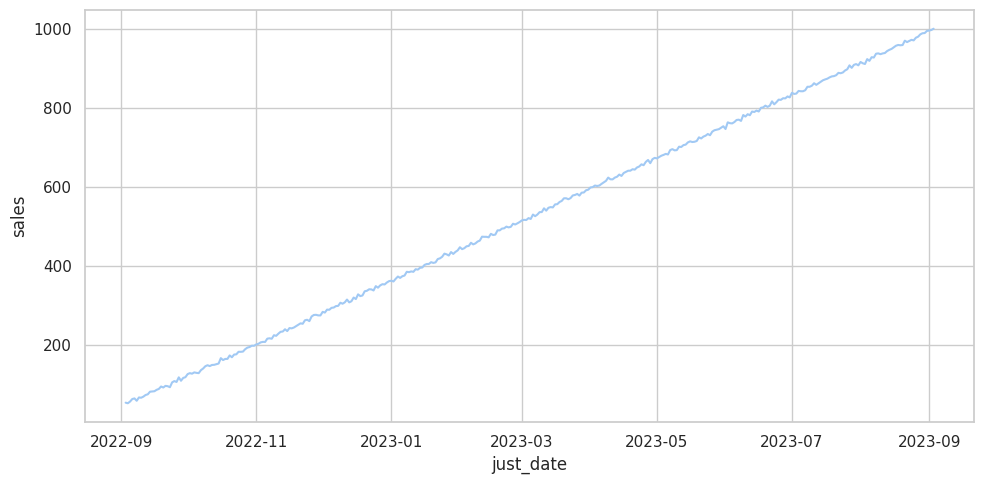

In [3]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

### Paso 2. Análisis de una serie temporal

En este caso deberemos responder a las siguientes preguntas:


    ¿Cuál es el tensor de la serie temporal?
    ¿Cuál es la tendencia?
    ¿Es estacionaria?
    ¿Existe variabilidad o presencia de ruido?

    Nota: Un tensor en una serie temporal es la unidad de tiempo mínima para la cual hay datos. Puede ser cada segundo, minuto, hora, día, semana, mes...

Por lo tanto, llevaremos a cabo los pasos que se observarán a continuación para poder responderlas gradualmente.

Descomposición de la serie temporal:

En primer lugar debemos despomponer la serie temporal (estadística) que nos servirá para separar la serie temporal en diversos elementos: tendencia, estacionalidad y residuos, que se verán a continuación en los pasos siguientes:

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period = 12)
decomposition

En este caso observamos como tensores los meses, ya que serán el tiempo con que calcularemos el periodo en la descomposición, si bien es cierto que el tensor del dataset eran segundos.

Análisis de la tendencia:

Ahora se aplicará la descomposición para visualizar la tendencia de la serie temporal que estamos trabajando. 

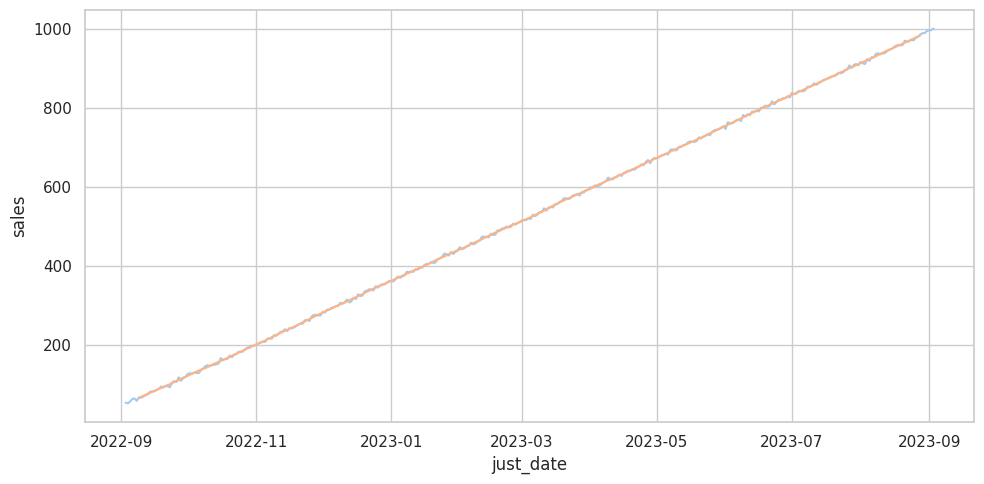

In [5]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

Podemos observar una clara tendencia ascendente continua de las ventas bastante lineal.

Análisis de la estacionalidad:

Ahora buscamos observar patrones repetitivos de nuestros datos. 

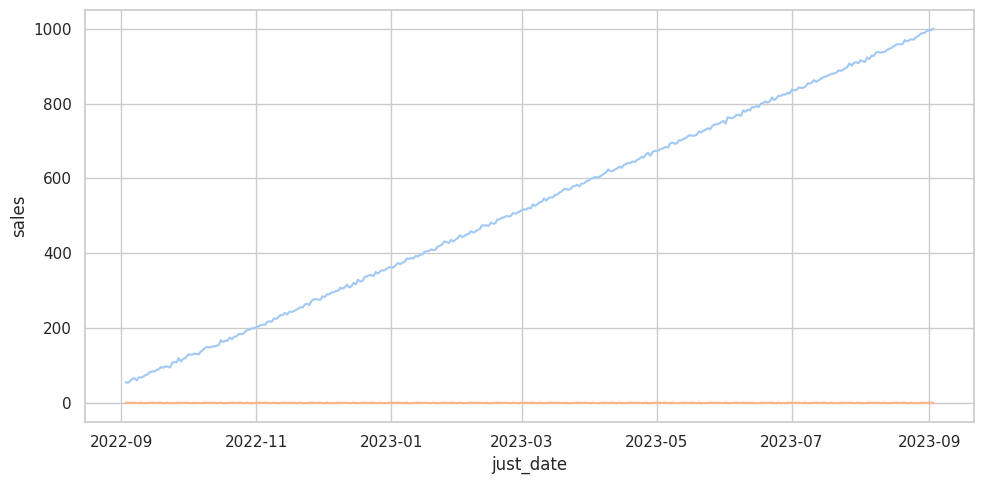

In [6]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

Como hemos comentado previamente es un dataset bastante uniforme donde no se observa estacionalidad y los datos aumentan en una pendiente positiva muy lineal y constante.

Con la prueba que llevaremos a cabo a continuación buscamos evaluar dicha estacionalidad con un contraste de H0.

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   0.55
p-value                          0.99
#Lags Used                      13.00
Number of Observations Used    352.00
Critical Value (1%)             -3.45
Critical Value (5%)             -2.87
Critical Value (10%)            -2.57
dtype: float64

Al ser p_value + 0.05 rechazamos H0 y por lo tanto confirmamos la no estacionalidad de los datos.

Análisis de variabilidad:

A continuación estudiaremos los residuos.

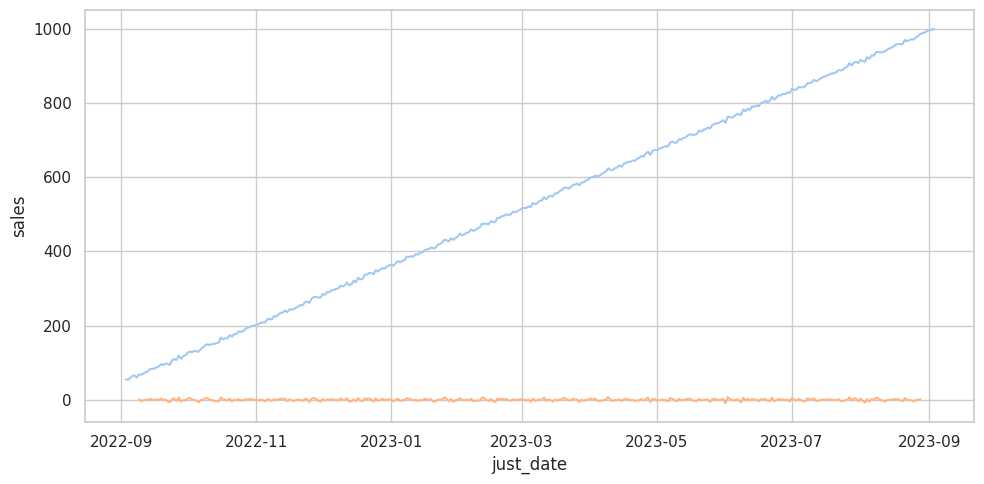

In [8]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

Como en los casos anteriores, al ser datos muy lineales y continuos no observamos grandes picos ni residuos.

Análisis de la autocorrelación:

Correlacionando la serie temporal con sus lags podemos observar si los valores de la serie temporal están correlacionados con los valores anteriores.

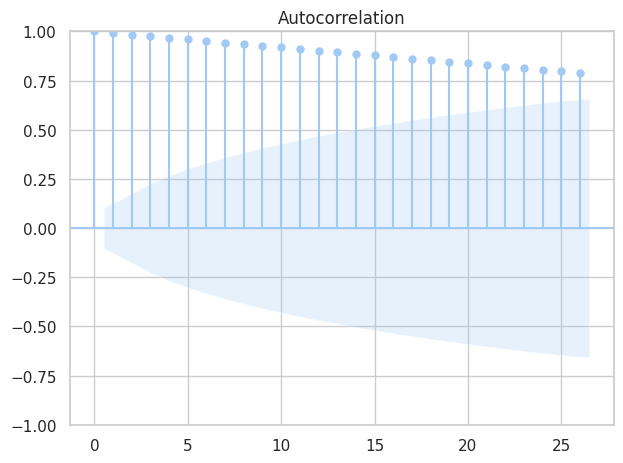

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(ts)

plt.tight_layout()

plt.show()

Se observa una gran correlación entre los valores de la serie temporal y sus lags si bien disminuye ligeramente a lo largo del tiempo.

### Paso 3: Entrena un ARIMA

Utiliza los datos de entrenamiento para encontrar la mejor parametrización de tu modelo ARIMA.

En el caso presente estimaremos internamente los hiperparámetros más apropiados para generar el mejor modelo posible con el paquete pmdarima y su función auto_arima. 

Para ello, a continuación y para optimizar al máximo sus resultados,transformaremos la serie en estacionaria para poder utilizarlo (dado que la nuestra no lo es).


In [10]:
ts_stationary = ts.diff().dropna()

test_stationarity(ts_stationary)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                -9.43e+00
p-value                        5.21e-16
#Lags Used                     1.20e+01
Number of Observations Used    3.52e+02
Critical Value (1%)           -3.45e+00
Critical Value (5%)           -2.87e+00
Critical Value (10%)          -2.57e+00
dtype: float64

A continuación aplicamos el modelo ARIMA automáticamente:

In [11]:
from pmdarima import auto_arima

model = auto_arima(ts_stationary, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=1847.118, Time=2.01 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=2096.542, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1972.854, Time=0.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=2209.657, Time=0.01 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=1845.127, Time=0.80 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=1843.049, Time=0.39 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=1845.092, Time=0.94 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=1843.587, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=1841.533, Time=0.33 sec
 ARIMA(2,0,1)(1,0,0)[12] intercept   : AIC=1843.435, Time=1.31 sec
 ARIMA(2,0,1)(0,0,1)[12] intercept   : AIC=1843.433, Time=1.18 sec
 ARIMA(2,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=1839.553, Time=0.25 sec
 ARIMA(1,0,1)(1,0,0)[12] inte

En este caso tendremos un ARIMA 1,0,1. 

A continuación devolveremos la información estadística del modelo:

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  365
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -915.776
Date:                Thu, 14 Aug 2025   AIC                           1839.553
Time:                        07:02:52   BIC                           1855.152
Sample:                    09-04-2022   HQIC                          1845.752
                         - 09-03-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.8110      0.134     21.055      0.000       2.549       3.073
ar.L1         -0.0821      0.052     -1.592      0.111      -0.183       0.019
ma.L1         -0.9413      0.020    -47.701      0.000      -0.980      -0.903
sigma2         8.7903      0.688     12.777      0.000       7.442      10.139
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.76
Prob(Q):                              1.00   Prob(JB):                         0.68
Heteroskedasticity (H):               0.90   Skew:                             0.07
Prob(H) (two-sided):                  0.58   Kurtosis:                         2.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Paso 4: Predice con el conjunto de test

Ahora utiliza el modelo entrenado con el conjunto de prueba y compara los puntos con los reales. Mide el rendimiento de la serie temporal.

En este caso lo utilizaremos para predecir a futuro la serie temporal, hemos elegido a 12 meses.

In [18]:
forecast = model.predict(12)
forecast

2023-09-04    1.68
2023-09-05    2.67
2023-09-06    2.59
2023-09-07    2.60
2023-09-08    2.60
2023-09-09    2.60
2023-09-10    2.60
2023-09-11    2.60
2023-09-12    2.60
2023-09-13    2.60
2023-09-14    2.60
2023-09-15    2.60
Freq: D, dtype: float64

Para visualizar la predicción anterior procedemos a graficar la predicción y vemos el forecast en rosa.

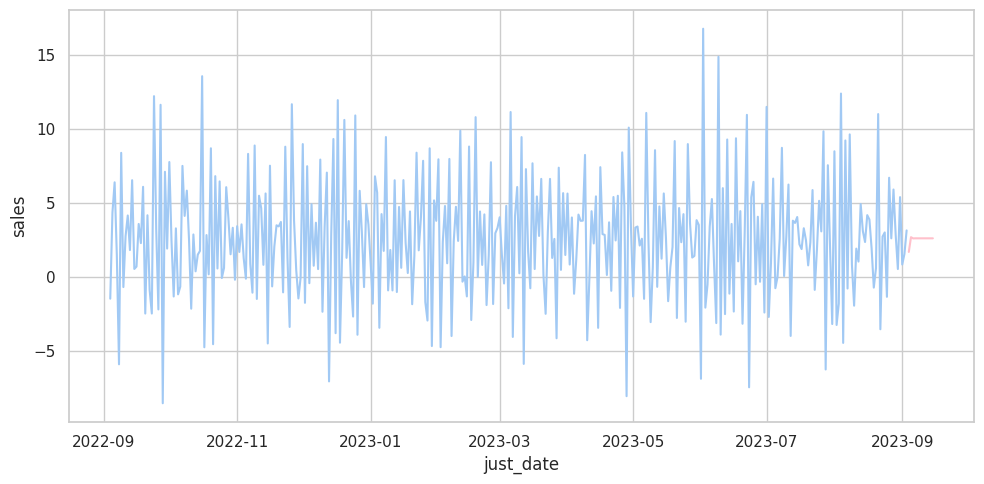

In [19]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts_stationary)
sns.lineplot(data = forecast, c = "pink")

plt.tight_layout()

plt.show()

Finalmente decidimos para nuestro cliente volver a transformar los datos a no estacionarios, tal cual él nos los ha enviado, pero para enseñarles su forecast, y su correspondiente gráfico.

In [15]:
last_level = ts.iloc[-1]
pred_level = forecast.cumsum() + last_level

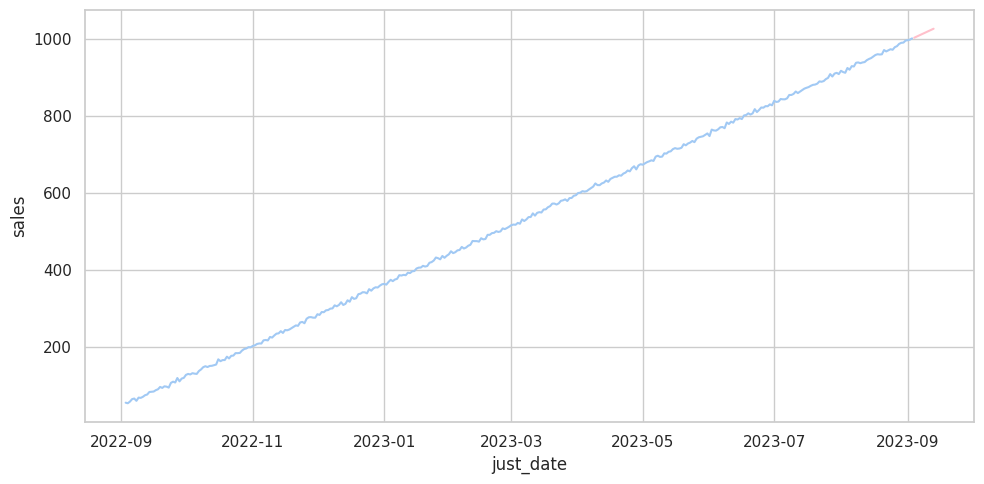

In [16]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = pred_level, c = "pink")

plt.tight_layout()

plt.show()

### 5. Guardado del modelo:

Guardamos el modelo para reutilizarlo si fuera necesario.

In [17]:
from pickle import dump

dump(model, open("/workspaces/ginappedrosa-ML-time_series-sales/models/timeseries_salespred_default.sav", "wb"))